# Genome visualization
This notebook is intended to explore a few ways to visualize the _P. amilis_ genome and genomic features like gene models. 

In [4]:
# Core
import re, os, glob, sys
import pandas as pd
from itertools import cycle, islice
import numpy as np
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import nxviz as nx

In [5]:
import pygenometracks as pgt

In [129]:
bed = pgt.tracks.ReadBed(open("/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/P_amilis_R1.Scaffold_2366.bed", "r"))

Number of fields in BED file is not standard. Assuming bed6


In [127]:
for interval in bed:
    print(bed["start"])

AssertionError: File type detected is bed6 but line 2: Scaffold_1	0	1270	Scaffold_1	.	.	.	contig	.	ID=Scaffold_1;Name=Scaffold_1
 does not have 6 fields.

## Sandbox
### Reorganizing `gff` files
**Problem:** `GFF3` files are supposed to have sequence regions with headers that indicate the genome region and the start and stop positions of that region. 
```
##gff-version 3.2.1
##sequence-region ctg123 1 1497228
ctg123 . gene            1000 9000  .  +  .  ID=gene00001;Name=EDEN
ctg123 . TF_binding_site 1000 1012  .  +  .  Parent=gene00001
ctg123 . mRNA            1050 9000  .  +  .  ID=mRNA00001;Parent=gene00001
ctg123 . mRNA            1050 9000  .  +  .  ID=mRNA00002;Parent=gene00001
ctg123 . mRNA            1300 9000  .  +  .  ID=mRNA00003;Parent=gene00001
```

All features in the region are then listed below that header. Currently I have no sequence headers and features from the same region (scaffold in my case) are scattered through the file.

**Goal:** Rearrange my features under single headers and add start and stop positions to those region headers.

In [58]:
faipath = "/Users/iangilman/Dropbox/P_amilis_genome_project/portulaca_26Nov2018_oK3Ko.fixed.fasta.fai"
fai = pd.read_csv(filepath_or_buffer=faipath, sep="\t", usecols=[0,1], names=["name", "length"])

Quick visual check that I'm reading the `.fai` correctly. The cumulative sum of all of the regions should add up to the total length of the genome.

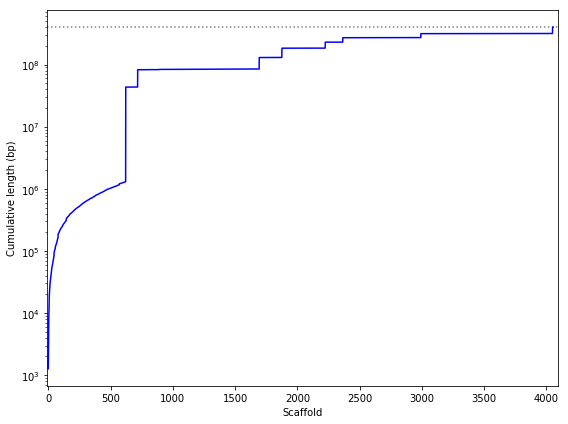

In [71]:
fig, ax = plt.subplots(figsize=(8,6))

genome_size = 403885173
ax.hlines(y=genome_size, xmin=-10, xmax=len(fai)*1.01, colors="grey", linestyles=":")

ax.plot(fai["length"].cumsum().index, fai["length"].cumsum(), c='blue')
ax.semilogy()

ax.set_xlabel("Scaffold")
ax.set_ylabel("Cumulative length (bp)")
ax.set_xlim([-10, len(fai)*1.01])

plt.tight_layout()

Now let's create a list of `GFF3` genomic region headers

In [118]:
def fai2gff3regions(fai_path):
    fai = pd.read_csv(filepath_or_buffer=fai_path, sep="\t", usecols=[0,1], names=["name", "length"])
    
    cumsum = fai["length"].cumsum()
    
    gff3regions = []
    for i in range(len(cumsum)):
        if i==0:
            gff3regions.append("##sequence-region {} 1 {}\n".format(fai["name"][i], cumsum[i]))
        else:
            gff3regions.append("##sequence-region {} {} {}\n".format(fai["name"][i], cumsum[i-1]+1, cumsum[i]))
    return gff3regions

In [119]:
fai2gff3regions(fai_path=faipath)[:5]

['##sequence-region Scaffold_1 1 1270\n',
 '##sequence-region Scaffold_2 1271 2310\n',
 '##sequence-region Scaffold_3 2311 4140\n',
 '##sequence-region Scaffold_4 4141 5375\n',
 '##sequence-region Scaffold_5 5376 8555\n']

Moving on to the `gff` file itself; we'll extract just the lines with features.

In [120]:
gffpath = "/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/P_amilis_R1.all.maker.noseq.fixed.gff"
with open(gffpath, "r") as g:
    gfflines = [line for line in g.readlines() if not line.startswith("#")]
gfflines[:5]

['Scaffold_27\t.\tcontig\t1\t3334\t.\t.\t.\tID=Scaffold_27;Name=Scaffold_27\n',
 'Scaffold_27\trepeat_gff:repeatmasker\tmatch\t12\t199\t1173\t-\t.\tID=Scaffold_27:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +\n',
 'Scaffold_27\trepeat_gff:repeatmasker\tmatch_part\t12\t199\t1173\t-\t.\tID=Scaffold_27:hsp:39:1.3.0.0;Parent=Scaffold_27:hit:39:1.3.0.0;Target=342270 69 250 +\n',
 'Scaffold_27\trepeat_gff:repeatmasker\tmatch\t374\t3334\t8096\t+\t.\tID=Scaffold_27:hit:40:1.3.0.0;Name=342274;Target=342274 2731 3807 +\n',
 'Scaffold_27\trepeat_gff:repeatmasker\tmatch_part\t374\t3334\t8096\t+\t.\tID=Scaffold_27:hsp:40:1.3.0.0;Parent=Scaffold_27:hit:40:1.3.0.0;Target=342274 2731 3807 +\n']

In [121]:
gff = pd.DataFrame(gfflines, columns=["line"])
gff["region"] = [item[0] for item in gff["line"].str.split("\t", n=1)]
gff.head()

,line,region
0,Scaffold_27\t.\tcontig\t1\t3334\t.\t.\t.\tID=S...,Scaffold_27
1,Scaffold_27\trepeat_gff:repeatmasker\tmatch\t1...,Scaffold_27
2,Scaffold_27\trepeat_gff:repeatmasker\tmatch_pa...,Scaffold_27
3,Scaffold_27\trepeat_gff:repeatmasker\tmatch\t3...,Scaffold_27
4,Scaffold_27\trepeat_gff:repeatmasker\tmatch_pa...,Scaffold_27


Putting it all together...

In [122]:
gff3regions = pd.DataFrame(data=fai2gff3regions(fai_path=faipath), columns=["line"])
gff3regions["region"] = [item[1] for item in gff3regions["line"].str.split()]
gff3regions.head()

,line,region
0,##sequence-region Scaffold_1 1 1270\n,Scaffold_1
1,##sequence-region Scaffold_2 1271 2310\n,Scaffold_2
2,##sequence-region Scaffold_3 2311 4140\n,Scaffold_3
3,##sequence-region Scaffold_4 4141 5375\n,Scaffold_4
4,##sequence-region Scaffold_5 5376 8555\n,Scaffold_5


In [124]:
output = "/Users/iangilman/Dropbox/P_amilis_genome_project/P_amilis_R1.all.noseq.organized.gff"
with open(output, "w+") as o:
    for i,region in enumerate(gff3regions["region"]):
        o.writelines([gff3regions["line"][i]]+list(gff[gff["region"]==region]["line"]))

In [130]:
gff3regions[gff3regions["region"]=="Scaffold_2366"]

,line,region
2365,##sequence-region Scaffold_2366 230290449 2712...,Scaffold_2366


In [ ]:
230290449